In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 741
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  HS78Q8CD_22_36_29
NN-MODEL FILENAME:  ./models/HS78Q8CD_22_36_29_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.intp)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax().astype(np.intp)
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.intp)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1265.66 MiB, increment: 1045.75 MiB
Quantization TIME:  0.01 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   13564
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 46
TOTAL SERIAL TIMESTEPS:   13564
TOTAL PARALLEL TIMESTEPS: 46


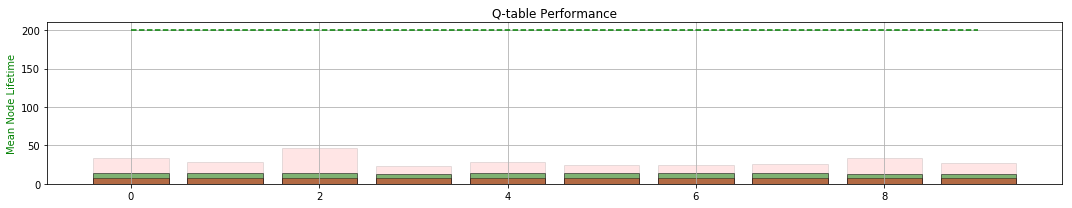

MEMORY COUNTER:  13564
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 670.059	LOSS : 597.176	LOSS : 571.106	LOSS : 587.948	LOSS : 557.282	LOSS : 560.053	LOSS : 560.552	LOSS : 546.854	LOSS : 547.518	LOSS : 549.678	LOSS : 539.268	LOSS : 543.082	LOSS : 531.612	LOSS : 517.937	LOSS : 514.086	LOSS : 510.245	LOSS : 513.494	LOSS : 523.680	LOSS : 498.405	LOSS : 496.337	
Validating... MEAN TIME:  94.815
LOSS : 496.460	LOSS : 504.150	LOSS : 482.099	LOSS : 475.896	LOSS : 469.915	LOSS : 486.066	LOSS : 482.009	LOSS : 472.458	LOSS : 470.097	LOSS : 466.027	LOSS : 462.378	LOSS : 472.685	LOSS : 465.002	LOSS : 467.293	LOSS : 472.711	LOSS : 475.057	LOSS : 456.361	LOSS : 486.361	LOSS : 477.160	LOSS : 459.285	
Validating... MEAN TIME:  98.835
LOSS : 454.968	LOSS : 477.633	LOSS : 473.425	LOSS : 465.397	LOSS : 463.978	LOSS : 484.260	LOSS : 479.922	LOSS : 479.595	LOSS : 483.838	LOSS : 484.216	LOSS : 488.429	LOSS : 489.362	LOSS : 475.851	LOSS : 495.619	LOSS : 472.197	LOSS : 493.762	LOSS : 505

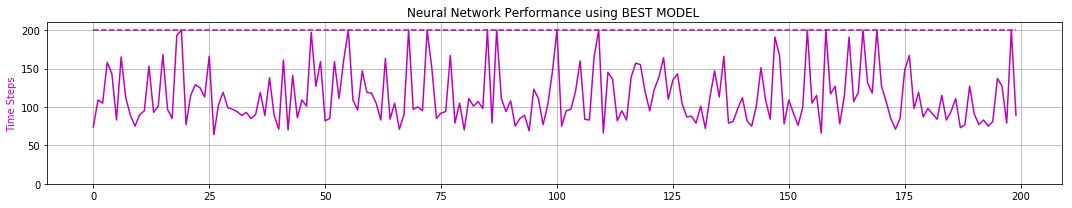

peak memory: 1337.86 MiB, increment: 1060.29 MiB
0 -max- [ 0.330  2.903  0.208  2.905]
0 -min- [-0.233 -1.958 -0.209 -3.415]

1 -max- [ 0.202  1.928  0.209  2.719]
1 -min- [-0.188 -1.776 -0.209 -2.744]

2 -max- [ 0.222  1.971  0.206  2.748]
2 -min- [-0.190 -1.912 -0.209 -2.967]

3 -max- [ 0.215  1.919  0.209  2.753]
3 -min- [-0.203 -1.752 -0.208 -2.945]

4 -max- [ 0.231  1.743  0.208  2.690]
4 -min- [-0.175 -1.794 -0.207 -2.742]

5 -max- [ 0.212  1.981  0.209  2.740]
5 -min- [-0.198 -1.794 -0.208 -2.781]

6 -max- [ 0.220  1.782  0.208  2.694]
6 -min- [-0.187 -1.755 -0.209 -2.759]

7 -max- [ 0.212  1.801  0.208  2.472]
7 -min- [-0.172 -1.611 -0.209 -2.732]

8 -max- [ 0.217  1.798  0.208  2.827]
8 -min- [-0.229 -1.901 -0.209 -2.666]

9 -max- [ 0.225  1.989  0.209  2.708]
9 -min- [-0.193 -1.746 -0.209 -2.962]

Quantization TIME:  0.01 minutes


ITERATION # 1
TOTAL EXPERIENCE GENERATED:   92113
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   105677
TOTAL PARALLEL TIM

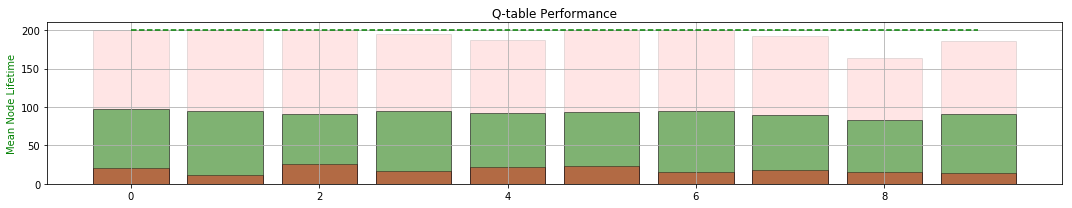

MEMORY COUNTER:  105677
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 603.265	LOSS : 593.125	LOSS : 524.892	LOSS : 485.056	LOSS : 453.910	LOSS : 414.429	LOSS : 376.243	LOSS : 326.234	LOSS : 315.498	LOSS : 278.067	LOSS : 273.287	LOSS : 244.954	LOSS : 253.060	LOSS : 245.809	LOSS : 235.615	LOSS : 220.786	LOSS : 220.674	LOSS : 202.761	LOSS : 210.641	LOSS : 221.711	
Validating... MEAN TIME:  128.815
LOSS : 209.289	LOSS : 208.300	LOSS : 207.548	LOSS : 209.991	LOSS : 202.946	LOSS : 216.953	LOSS : 204.846	LOSS : 213.344	LOSS : 214.334	LOSS : 220.639	LOSS : 212.284	LOSS : 213.002	LOSS : 207.971	LOSS : 233.364	LOSS : 210.725	LOSS : 217.744	LOSS : 216.043	LOSS : 217.064	LOSS : 206.074	LOSS : 214.232	
Validating... MEAN TIME:  112.63
LOSS : 217.643	LOSS : 210.565	LOSS : 222.818	LOSS : 228.842	LOSS : 218.112	LOSS : 223.076	LOSS : 227.743	LOSS : 205.030	LOSS : 216.275	LOSS : 215.585	LOSS : 241.068	LOSS : 230.222	LOSS : 226.921	LOSS : 217.688	LOSS : 222.166	LOSS : 230.335	LOSS : 2

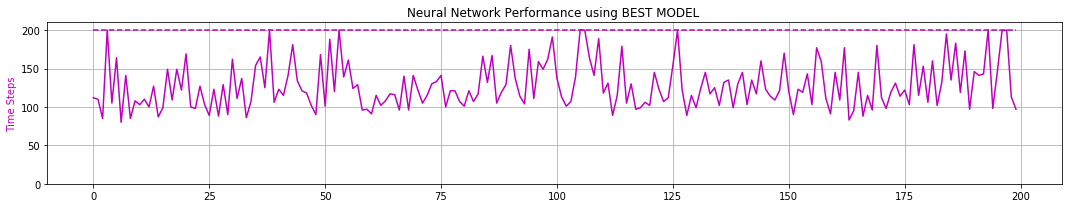

peak memory: 1425.64 MiB, increment: 1079.01 MiB
0 -max- [ 0.585  1.352  0.209  1.635]
0 -min- [-0.655 -1.689 -0.209 -2.104]

1 -max- [ 0.517  1.338  0.209  1.681]
1 -min- [-0.561 -1.675 -0.209 -1.890]

2 -max- [ 0.537  1.354  0.209  1.493]
2 -min- [-0.589 -1.541 -0.209 -1.736]

3 -max- [ 0.669  1.502  0.209  1.719]
3 -min- [-0.603 -1.503 -0.209 -1.654]

4 -max- [ 0.544  1.377  0.209  1.807]
4 -min- [-0.658 -1.714 -0.209 -1.940]

5 -max- [ 0.701  1.714  0.209  2.107]
5 -min- [-0.633 -1.706 -0.209 -1.683]

6 -max- [ 0.676  1.488  0.209  1.718]
6 -min- [-0.500 -1.316 -0.209 -1.943]

7 -max- [ 0.533  1.413  0.209  1.636]
7 -min- [-1.255 -1.882 -0.209 -2.246]

8 -max- [ 0.586  1.491  0.209  1.877]
8 -min- [-0.663 -1.356 -0.209 -1.790]

9 -max- [ 0.685  1.866  0.209  1.833]
9 -min- [-0.591 -1.542 -0.209 -2.155]

Quantization TIME:  0.02 minutes


ITERATION # 2
TOTAL EXPERIENCE GENERATED:   118879
SMALLEST TIMESTEP: 22
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   224556
TOTAL PARALLEL TI

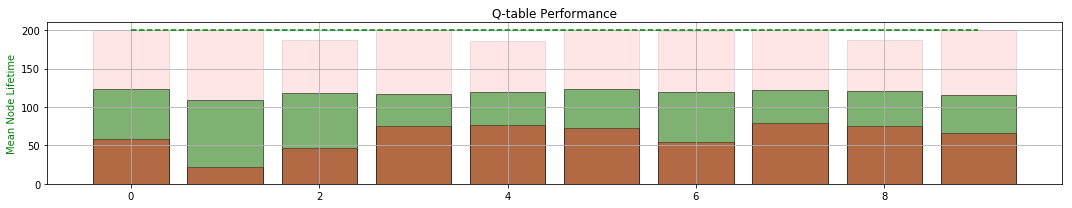

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 133.723	LOSS : 132.969	LOSS : 125.132	LOSS : 114.263	LOSS : 109.715	LOSS : 109.624	LOSS : 106.592	LOSS : 111.566	LOSS : 108.547	LOSS : 112.844	LOSS : 109.933	LOSS : 114.619	LOSS : 104.555	LOSS : 106.656	LOSS : 96.112	LOSS : 89.654	LOSS : 96.473	LOSS : 105.337	LOSS : 92.826	LOSS : 98.965	
Validating... MEAN TIME:  187.885
LOSS : 95.511	LOSS : 104.837	LOSS : 95.269	LOSS : 91.241	LOSS : 97.914	LOSS : 97.583	LOSS : 91.622	LOSS : 86.544	LOSS : 92.981	LOSS : 93.864	LOSS : 99.079	LOSS : 90.395	LOSS : 88.398	LOSS : 97.921	LOSS : 95.414	LOSS : 88.135	LOSS : 90.412	LOSS : 87.998	LOSS : 86.360	LOSS : 88.743	
Validating... MEAN TIME:  194.31
LOSS : 91.235	LOSS : 92.917	LOSS : 89.392	LOSS : 92.758	LOSS : 86.436	LOSS : 91.147	LOSS : 96.007	LOSS : 85.849	LOSS : 90.713	LOSS : 95.714	LOSS : 83.634	LOSS : 86.508	LOSS : 89.992	LOSS : 87.150	LOSS : 82.414	LOSS : 83.220	LOSS : 84.094	LOSS : 93.813	LOSS : 89.217	LOSS :

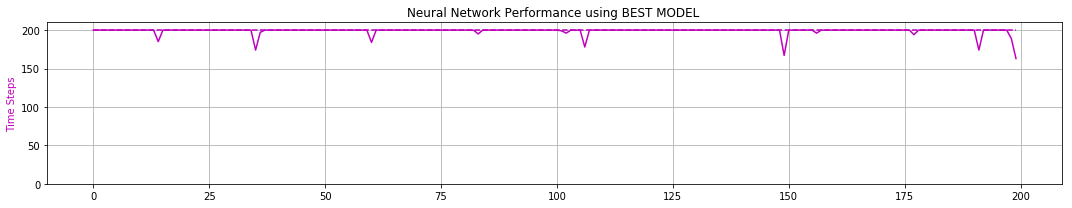

peak memory: 1442.99 MiB, increment: 1074.29 MiB
0 -max- [ 0.779  1.494  0.209  1.432]
0 -min- [-0.877 -1.842 -0.209 -1.293]

1 -max- [ 0.803  1.342  0.209  1.487]
1 -min- [-0.942 -1.802 -0.209 -1.695]

2 -max- [ 0.825  1.631  0.209  1.335]
2 -min- [-0.937 -1.851 -0.209 -1.930]

3 -max- [ 0.826  1.525  0.209  1.468]
3 -min- [-0.977 -1.869 -0.209 -1.492]

4 -max- [ 0.833  1.698  0.209  1.168]
4 -min- [-0.942 -1.834 -0.209 -1.293]

5 -max- [ 0.836  1.465  0.209  1.530]
5 -min- [-1.049 -2.245 -0.209 -1.598]

6 -max- [ 0.871  1.473  0.209  1.456]
6 -min- [-0.910 -1.794 -0.209 -1.590]

7 -max- [ 0.873  1.693  0.209  1.692]
7 -min- [-0.990 -1.851 -0.209 -1.491]

8 -max- [ 0.874  1.504  0.209  1.867]
8 -min- [-0.950 -1.837 -0.209 -1.441]

9 -max- [ 0.885  1.697  0.209  1.260]
9 -min- [-0.878 -1.698 -0.209 -1.697]

Quantization TIME:  0.02 minutes


ITERATION # 3
TOTAL EXPERIENCE GENERATED:   103429
SMALLEST TIMESTEP: 80
LARGEST  TIMESTEP: 153
TOTAL SERIAL TIMESTEPS:   327985
TOTAL PARALLEL TI

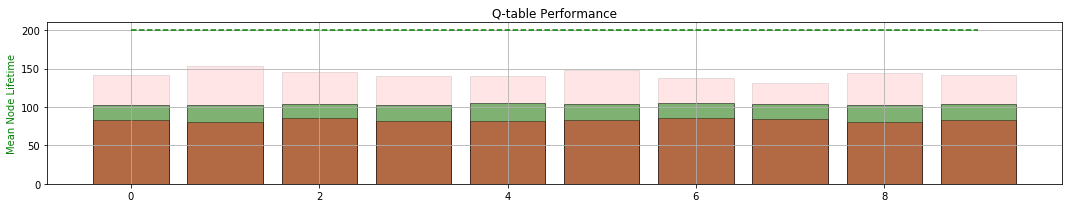

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 100.899	LOSS : 82.997	LOSS : 70.534	LOSS : 72.209	LOSS : 67.735	LOSS : 79.633	LOSS : 74.948	LOSS : 70.542	LOSS : 71.376	LOSS : 71.694	LOSS : 74.830	LOSS : 73.016	LOSS : 71.330	LOSS : 72.931	LOSS : 75.340	LOSS : 76.377	LOSS : 74.850	LOSS : 78.856	LOSS : 70.891	LOSS : 73.238	
Validating... MEAN TIME:  150.55
LOSS : 73.713	LOSS : 75.267	LOSS : 78.919	LOSS : 70.067	LOSS : 73.714	LOSS : 75.444	LOSS : 78.572	LOSS : 70.172	LOSS : 77.514	LOSS : 89.321	LOSS : 82.922	LOSS : 78.597	LOSS : 74.891	LOSS : 74.948	LOSS : 79.638	LOSS : 74.431	LOSS : 81.300	LOSS : 72.625	LOSS : 76.788	LOSS : 79.966	
Validating... MEAN TIME:  168.425
LOSS : 76.814	LOSS : 74.626	LOSS : 73.171	LOSS : 80.190	LOSS : 76.184	LOSS : 79.365	LOSS : 69.446	LOSS : 78.322	LOSS : 77.217	LOSS : 80.712	LOSS : 79.986	LOSS : 73.260	LOSS : 73.066	LOSS : 70.476	LOSS : 71.187	LOSS : 74.095	LOSS : 72.146	LOSS : 77.616	LOSS : 77.219	LOSS : 70.505	
Valida

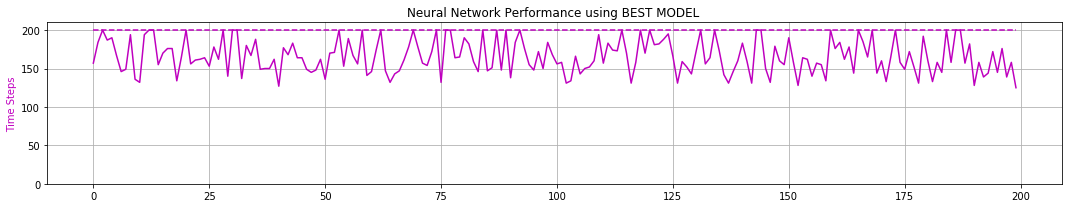

peak memory: 1458.52 MiB, increment: 989.97 MiB
0 -max- [ 0.144  0.600  0.048  0.695]
0 -min- [-0.948 -1.658 -0.209 -1.029]

1 -max- [ 0.148  0.612  0.050  0.680]
1 -min- [-0.976 -1.668 -0.209 -1.095]

2 -max- [ 0.124  0.616  0.049  0.672]
2 -min- [-0.992 -1.803 -0.209 -1.061]

3 -max- [ 0.159  0.434  0.049  0.673]
3 -min- [-1.091 -1.813 -0.209 -1.043]

4 -max- [ 0.153  0.627  0.051  0.694]
4 -min- [-1.040 -1.661 -0.209 -0.899]

5 -max- [ 0.143  0.439  0.049  0.696]
5 -min- [-0.947 -1.655 -0.209 -1.037]

6 -max- [ 0.157  0.439  0.050  0.687]
6 -min- [-0.973 -1.621 -0.209 -0.958]

7 -max- [ 0.137  0.547  0.049  0.687]
7 -min- [-0.930 -1.651 -0.209 -1.102]

8 -max- [ 0.164  0.589  0.049  0.686]
8 -min- [-0.903 -1.617 -0.209 -0.983]

9 -max- [ 0.136  0.440  0.050  0.700]
9 -min- [-0.991 -1.666 -0.209 -1.047]

Quantization TIME:  0.02 minutes


ITERATION # 4
TOTAL EXPERIENCE GENERATED:   138352
SMALLEST TIMESTEP: 71
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   466337
TOTAL PARALLEL TIM

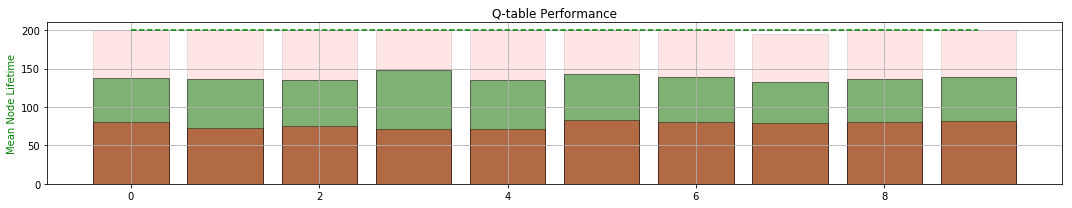

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 105.005	LOSS : 101.330	LOSS : 94.909	LOSS : 94.830	LOSS : 90.962	LOSS : 106.027	LOSS : 106.746	LOSS : 108.872	LOSS : 96.549	LOSS : 99.073	LOSS : 100.779	LOSS : 94.787	LOSS : 110.286	LOSS : 105.765	LOSS : 107.797	LOSS : 102.100	LOSS : 94.578	LOSS : 105.676	LOSS : 91.454	LOSS : 102.972	
Validating... MEAN TIME:  163.27
LOSS : 94.096	LOSS : 92.460	LOSS : 91.339	LOSS : 95.446	LOSS : 98.260	LOSS : 107.102	LOSS : 94.088	LOSS : 96.323	LOSS : 95.122	LOSS : 107.919	LOSS : 101.418	LOSS : 92.647	LOSS : 90.358	LOSS : 98.445	LOSS : 110.144	LOSS : 97.483	LOSS : 103.537	LOSS : 106.454	LOSS : 86.963	LOSS : 99.030	
Validating... MEAN TIME:  110.225
LOSS : 104.056	LOSS : 98.699	LOSS : 104.074	LOSS : 101.476	LOSS : 97.439	LOSS : 92.103	LOSS : 97.164	LOSS : 93.782	LOSS : 78.310	LOSS : 83.794	LOSS : 88.212	LOSS : 91.144	LOSS : 101.193	LOSS : 99.323	LOSS : 109.721	LOSS : 92.309	LOSS : 83.971	LOSS : 96.540	LOSS : 80.303

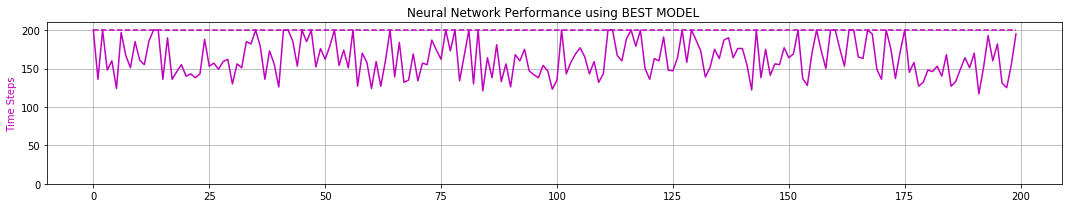

peak memory: 1485.98 MiB, increment: 1017.55 MiB
0 -max- [ 2.050  2.358  0.209  1.338]
0 -min- [-2.400 -3.147 -0.209 -1.284]

1 -max- [ 2.047  2.371  0.208  1.258]
1 -min- [-2.398 -3.156 -0.209 -1.309]

2 -max- [ 1.846  2.205  0.209  1.233]
2 -min- [-2.399 -3.121 -0.209 -1.322]

3 -max- [ 2.001  2.390  0.208  1.256]
3 -min- [-2.399 -3.159 -0.209 -1.319]

4 -max- [ 1.916  2.228  0.209  1.225]
4 -min- [-2.399 -3.092 -0.209 -1.385]

5 -max- [ 1.966  2.344  0.209  1.150]
5 -min- [-2.395 -3.146 -0.209 -1.305]

6 -max- [ 2.102  2.406  0.209  1.348]
6 -min- [-2.396 -3.165 -0.209 -1.412]

7 -max- [ 2.092  2.399  0.209  1.549]
7 -min- [-2.399 -3.341 -0.209 -1.377]

8 -max- [ 2.054  2.427  0.209  1.210]
8 -min- [-2.398 -3.149 -0.209 -1.420]

9 -max- [ 2.072  2.360  0.209  1.158]
9 -min- [-2.397 -3.159 -0.209 -1.392]

Quantization TIME:  0.02 minutes


ITERATION # 5
TOTAL EXPERIENCE GENERATED:   99766
SMALLEST TIMESTEP: 32
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   566103
TOTAL PARALLEL TIM

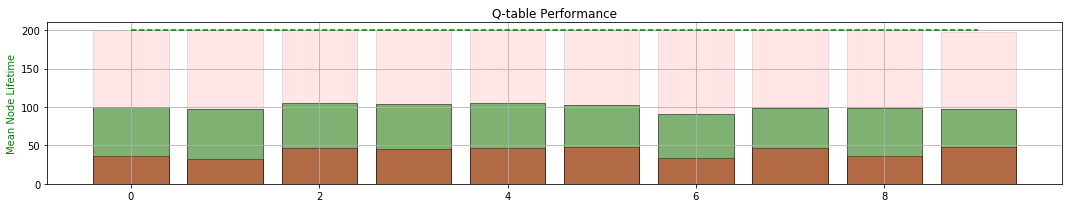

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 100.582	LOSS : 98.017	LOSS : 95.049	LOSS : 96.306	LOSS : 102.745	LOSS : 103.212	LOSS : 93.193	LOSS : 102.141	LOSS : 92.556	LOSS : 87.965	LOSS : 91.680	LOSS : 83.743	LOSS : 88.148	LOSS : 100.741	LOSS : 97.131	LOSS : 88.186	LOSS : 92.318	LOSS : 80.633	LOSS : 85.190	LOSS : 88.606	
Validating... MEAN TIME:  136.055
LOSS : 88.675	LOSS : 86.496	LOSS : 91.791	LOSS : 93.066	LOSS : 90.608	LOSS : 93.344	LOSS : 85.211	LOSS : 94.899	LOSS : 88.392	LOSS : 79.941	LOSS : 84.570	LOSS : 90.486	LOSS : 96.253	LOSS : 84.916	LOSS : 89.268	LOSS : 87.940	LOSS : 96.239	LOSS : 92.035	LOSS : 99.891	LOSS : 95.784	
Validating... MEAN TIME:  106.02
LOSS : 102.787	LOSS : 92.739	LOSS : 90.157	LOSS : 92.320	LOSS : 82.763	LOSS : 93.471	LOSS : 84.030	LOSS : 95.639	LOSS : 84.615	LOSS : 101.967	LOSS : 91.461	LOSS : 90.022	LOSS : 93.161	LOSS : 82.693	LOSS : 96.488	LOSS : 90.036	LOSS : 101.110	LOSS : 88.996	LOSS : 93.619	LOSS : 113.545

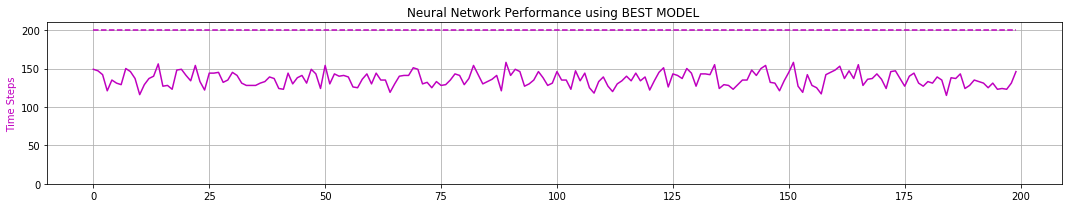

peak memory: 1444.13 MiB, increment: 1053.71 MiB
0 -max- [ 2.396  2.549  0.206  1.973]
0 -min- [-1.516 -2.345 -0.209 -1.315]

1 -max- [ 2.383  2.417  0.208  1.997]
1 -min- [-1.674 -2.360 -0.209 -1.288]

2 -max- [ 2.392  2.606  0.208  2.162]
2 -min- [-1.007 -1.884 -0.209 -1.433]

3 -max- [ 2.390  2.531  0.209  2.009]
3 -min- [-1.688 -2.389 -0.209 -1.415]

4 -max- [ 2.393  2.608  0.208  1.997]
4 -min- [-1.005 -1.834 -0.209 -1.379]

5 -max- [ 2.393  2.523  0.207  2.154]
5 -min- [-1.071 -1.916 -0.209 -1.347]

6 -max- [ 2.394  2.574  0.207  2.167]
6 -min- [-1.518 -2.365 -0.209 -1.199]

7 -max- [ 2.397  2.518  0.207  2.084]
7 -min- [-1.960 -2.585 -0.209 -1.303]

8 -max- [ 2.391  2.518  0.208  2.264]
8 -min- [-1.541 -2.360 -0.209 -1.287]

9 -max- [ 2.390  2.540  0.209  2.081]
9 -min- [-1.491 -2.176 -0.209 -1.237]

Quantization TIME:  0.01 minutes


ITERATION # 6
TOTAL EXPERIENCE GENERATED:   73813
SMALLEST TIMESTEP: 55
LARGEST  TIMESTEP: 103
TOTAL SERIAL TIMESTEPS:   639916
TOTAL PARALLEL TIM

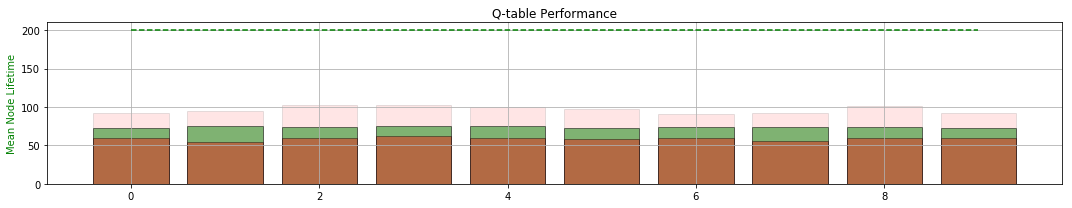

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 134.736	LOSS : 114.659	LOSS : 107.604	LOSS : 122.156	LOSS : 101.105	LOSS : 109.157	LOSS : 98.542	LOSS : 108.730	LOSS : 101.889	LOSS : 113.397	LOSS : 106.002	LOSS : 106.160	LOSS : 113.715	LOSS : 96.131	LOSS : 108.662	LOSS : 121.936	LOSS : 114.154	LOSS : 132.359	LOSS : 114.123	LOSS : 111.984	
Validating... MEAN TIME:  174.59
LOSS : 120.558	LOSS : 135.456	LOSS : 127.500	LOSS : 108.853	LOSS : 126.436	LOSS : 139.155	LOSS : 132.455	LOSS : 130.937	LOSS : 144.491	LOSS : 143.929	LOSS : 142.274	LOSS : 117.731	LOSS : 133.181	LOSS : 129.781	LOSS : 119.988	LOSS : 134.058	LOSS : 136.988	LOSS : 126.898	LOSS : 142.282	LOSS : 141.504	
Validating... MEAN TIME:  96.615
LOSS : 125.477	LOSS : 115.674	LOSS : 123.028	LOSS : 123.878	LOSS : 118.712	LOSS : 136.207	LOSS : 122.492	LOSS : 118.814	LOSS : 125.921	LOSS : 123.123	LOSS : 107.420	LOSS : 112.203	LOSS : 128.051	LOSS : 125.282	LOSS : 113.684	LOSS : 106.466	LOSS : 112.

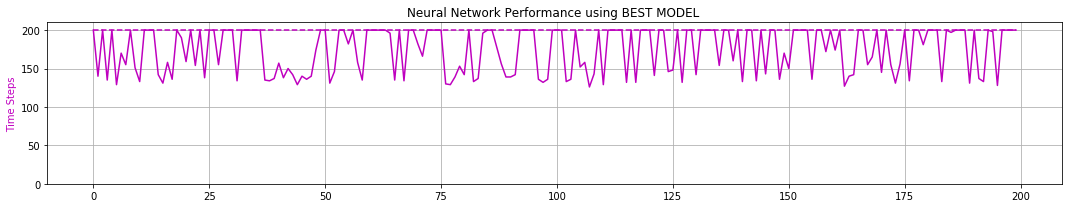

peak memory: 1430.34 MiB, increment: 981.04 MiB
0 -max- [ 0.172  0.625  0.049  0.743]
0 -min- [-1.437 -2.352 -0.209 -1.110]

1 -max- [ 0.165  0.635  0.051  0.806]
1 -min- [-1.462 -2.343 -0.209 -1.125]

2 -max- [ 0.168  0.630  0.049  0.942]
2 -min- [-1.625 -2.389 -0.209 -1.081]

3 -max- [ 0.174  0.633  0.050  0.878]
3 -min- [-1.780 -2.392 -0.209 -0.980]

4 -max- [ 0.161  0.738  0.049  0.874]
4 -min- [-1.707 -2.558 -0.209 -1.216]

5 -max- [ 0.175  0.633  0.049  0.883]
5 -min- [-1.456 -2.347 -0.209 -1.111]

6 -max- [ 0.150  0.617  0.050  0.810]
6 -min- [-1.396 -2.342 -0.209 -1.025]

7 -max- [ 0.143  0.622  0.049  0.705]
7 -min- [-1.241 -2.151 -0.209 -1.086]

8 -max- [ 0.206  0.628  0.051  0.823]
8 -min- [-1.626 -2.423 -0.209 -1.109]

9 -max- [ 0.150  0.624  0.050  0.703]
9 -min- [-1.499 -2.372 -0.209 -1.110]

Quantization TIME:  0.02 minutes


ITERATION # 7
TOTAL EXPERIENCE GENERATED:   74780
SMALLEST TIMESTEP: 22
LARGEST  TIMESTEP: 121
TOTAL SERIAL TIMESTEPS:   714696
TOTAL PARALLEL TIME

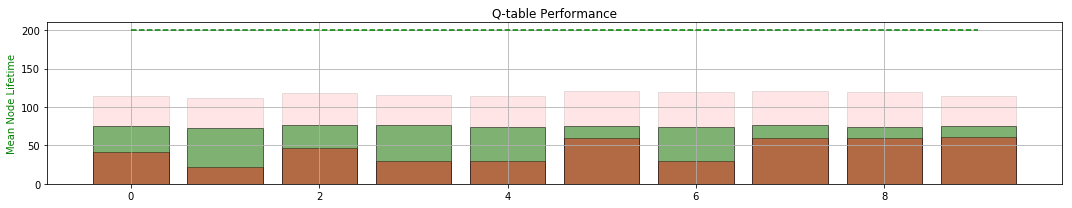

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 135.423	LOSS : 134.903	LOSS : 158.271	LOSS : 142.036	LOSS : 155.237	LOSS : 149.908	LOSS : 139.736	LOSS : 130.127	LOSS : 136.567	LOSS : 154.610	LOSS : 148.693	LOSS : 140.571	LOSS : 134.028	LOSS : 130.445	LOSS : 119.338	LOSS : 140.159	LOSS : 129.075	LOSS : 133.728	LOSS : 132.076	LOSS : 134.302	
Validating... MEAN TIME:  109.65
LOSS : 142.638	LOSS : 146.117	LOSS : 148.902	LOSS : 146.250	LOSS : 156.667	LOSS : 142.949	LOSS : 132.057	LOSS : 124.857	LOSS : 124.519	LOSS : 137.112	LOSS : 123.635	LOSS : 116.312	LOSS : 122.298	LOSS : 135.406	LOSS : 106.449	LOSS : 105.764	LOSS : 118.187	LOSS : 130.251	LOSS : 115.565	LOSS : 140.427	
Validating... MEAN TIME:  117.025
LOSS : 123.052	LOSS : 139.089	LOSS : 112.197	LOSS : 122.031	LOSS : 126.265	LOSS : 123.524	LOSS : 117.240	LOSS : 118.594	LOSS : 102.453	LOSS : 122.856	LOSS : 130.822	LOSS : 116.347	LOSS : 119.951	LOSS : 132.601	LOSS : 112.740	LOSS : 129.843	LOSS : 1

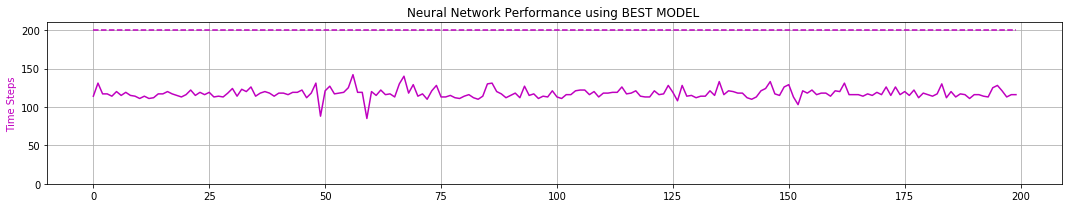

peak memory: 1483.88 MiB, increment: 993.08 MiB
0 -max- [ 0.194  0.632  0.191  2.293]
0 -min- [-2.399 -3.119 -0.209 -1.541]

1 -max- [ 0.184  0.763  0.158  1.965]
1 -min- [-2.395 -2.960 -0.209 -1.593]

2 -max- [ 0.190  0.660  0.200  1.793]
2 -min- [-2.399 -3.128 -0.209 -1.851]

3 -max- [ 0.181  0.634  0.089  1.836]
3 -min- [-2.386 -3.144 -0.209 -1.789]

4 -max- [ 0.196  0.621  0.140  1.860]
4 -min- [-2.391 -3.161 -0.209 -1.636]

5 -max- [ 0.173  0.631  0.117  1.775]
5 -min- [-2.398 -3.157 -0.209 -1.501]

6 -max- [ 0.164  0.757  0.117  1.735]
6 -min- [-2.382 -3.158 -0.209 -1.740]

7 -max- [ 0.218  0.774  0.106  1.802]
7 -min- [-2.394 -3.164 -0.209 -1.546]

8 -max- [ 0.179  0.609  0.128  1.742]
8 -min- [-2.392 -3.105 -0.209 -1.472]

9 -max- [ 0.183  0.578  0.085  1.730]
9 -min- [-2.397 -3.163 -0.209 -1.703]

Quantization TIME:  0.01 minutes


ITERATION # 8
TOTAL EXPERIENCE GENERATED:   59237
SMALLEST TIMESTEP: 15
LARGEST  TIMESTEP: 109
TOTAL SERIAL TIMESTEPS:   773933
TOTAL PARALLEL TIME

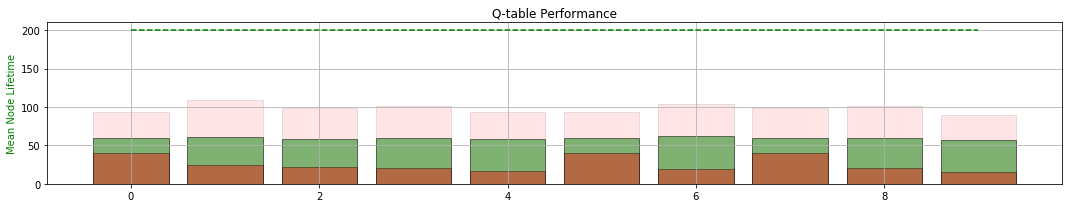

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 321.525	LOSS : 327.927	LOSS : 354.690	LOSS : 320.171	LOSS : 336.326	LOSS : 310.910	LOSS : 312.493	LOSS : 298.654	LOSS : 279.457	LOSS : 260.832	LOSS : 239.633	LOSS : 208.216	LOSS : 202.655	LOSS : 181.424	LOSS : 179.275	LOSS : 171.778	LOSS : 174.044	LOSS : 154.695	LOSS : 144.371	LOSS : 165.160	
Validating... MEAN TIME:  122.06
LOSS : 165.393	LOSS : 168.244	LOSS : 176.793	LOSS : 164.761	LOSS : 169.501	LOSS : 165.392	LOSS : 156.418	LOSS : 149.216	LOSS : 169.049	LOSS : 168.225	LOSS : 155.503	LOSS : 161.234	LOSS : 164.444	LOSS : 156.804	LOSS : 150.145	LOSS : 169.672	LOSS : 159.364	LOSS : 135.032	LOSS : 152.182	LOSS : 149.308	
Validating... MEAN TIME:  137.835
LOSS : 144.070	LOSS : 145.930	LOSS : 154.893	LOSS : 161.473	LOSS : 150.009	LOSS : 149.535	LOSS : 136.706	LOSS : 150.958	LOSS : 136.945	LOSS : 145.884	LOSS : 142.230	LOSS : 154.000	LOSS : 159.132	LOSS : 141.212	LOSS : 141.366	LOSS : 148.287	LOSS : 1

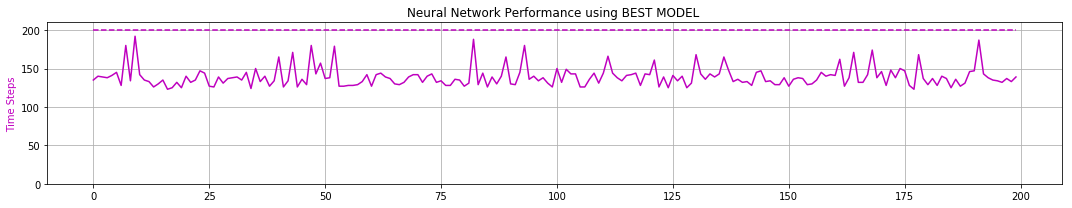

peak memory: 1503.41 MiB, increment: 978.49 MiB
0 -max- [ 0.200  0.799  0.209  2.593]
0 -min- [-2.053 -2.876 -0.209 -1.837]

1 -max- [ 0.187  0.804  0.209  2.573]
1 -min- [-2.400 -2.973 -0.209 -1.868]

2 -max- [ 0.184  0.803  0.208  2.709]
2 -min- [-1.564 -2.894 -0.209 -1.739]

3 -max- [ 0.191  0.812  0.209  2.838]
3 -min- [-2.355 -3.065 -0.209 -1.992]

4 -max- [ 0.163  0.827  0.209  2.594]
4 -min- [-1.525 -2.887 -0.209 -1.933]

5 -max- [ 0.164  0.821  0.209  2.789]
5 -min- [-1.555 -2.892 -0.209 -1.880]

6 -max- [ 0.217  0.823  0.209  2.671]
6 -min- [-2.356 -2.878 -0.209 -1.960]

7 -max- [ 0.176  0.784  0.207  2.657]
7 -min- [-2.302 -2.871 -0.209 -1.883]

8 -max- [ 0.182  0.753  0.209  2.592]
8 -min- [-2.361 -2.943 -0.209 -1.901]

9 -max- [ 0.189  0.777  0.209  2.858]
9 -min- [-1.540 -3.452 -0.209 -1.818]

Quantization TIME:  0.01 minutes


ITERATION # 9
TOTAL EXPERIENCE GENERATED:   55920
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 115
TOTAL SERIAL TIMESTEPS:   829853
TOTAL PARALLEL TIME

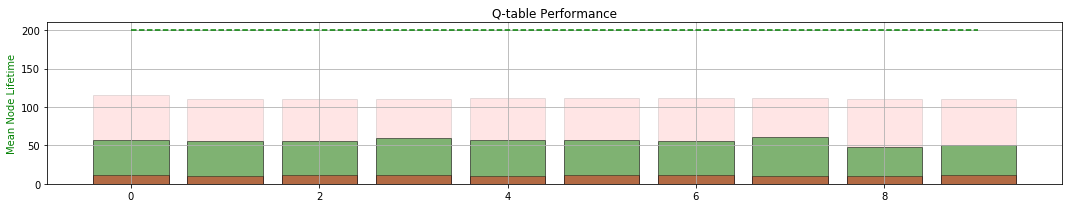

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 184.098	LOSS : 176.793	LOSS : 195.747	LOSS : 218.873	LOSS : 224.814	LOSS : 208.774	LOSS : 227.258	LOSS : 213.020	LOSS : 244.057	LOSS : 218.984	LOSS : 202.954	LOSS : 212.571	LOSS : 247.622	LOSS : 221.481	LOSS : 244.437	LOSS : 231.902	LOSS : 247.953	LOSS : 220.850	LOSS : 227.553	LOSS : 269.103	
Validating... MEAN TIME:  185.275
LOSS : 205.617	LOSS : 235.507	LOSS : 229.252	LOSS : 210.810	LOSS : 223.632	LOSS : 202.940	LOSS : 225.489	LOSS : 218.394	LOSS : 224.083	LOSS : 220.460	LOSS : 257.836	LOSS : 222.273	LOSS : 220.289	LOSS : 226.014	LOSS : 242.981	LOSS : 234.111	LOSS : 228.506	LOSS : 231.106	LOSS : 223.493	LOSS : 248.924	
Validating... MEAN TIME:  195.755
LOSS : 223.335	LOSS : 230.051	LOSS : 240.133	LOSS : 238.337	LOSS : 251.571	LOSS : 219.137	LOSS : 243.634	LOSS : 230.280	LOSS : 237.555	LOSS : 233.188	LOSS : 255.160	LOSS : 230.780	LOSS : 208.789	LOSS : 226.662	LOSS : 228.584	LOSS : 244.156	LOSS : 

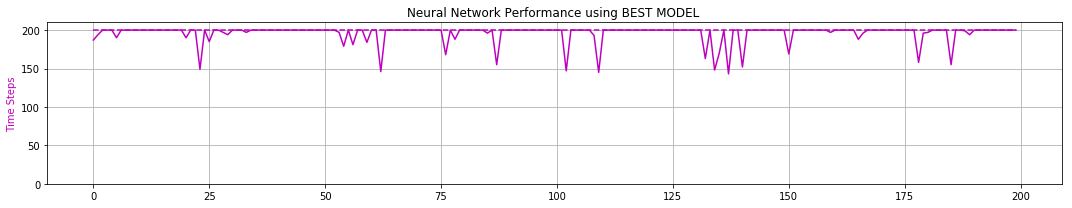

peak memory: 1445.92 MiB, increment: 1015.58 MiB
0 -max- [ 0.217  1.194  0.050  1.323]
0 -min- [-2.400 -3.119 -0.209 -1.681]

1 -max- [ 0.209  1.218  0.049  1.352]
1 -min- [-2.399 -3.132 -0.209 -1.803]

2 -max- [ 0.216  1.324  0.049  1.434]
2 -min- [-2.399 -3.251 -0.209 -1.976]

3 -max- [ 0.192  1.218  0.050  1.309]
3 -min- [-2.400 -3.135 -0.209 -1.711]

4 -max- [ 0.196  1.217  0.049  1.514]
4 -min- [-2.399 -3.148 -0.209 -1.739]

5 -max- [ 0.238  1.213  0.051  1.335]
5 -min- [-2.396 -3.083 -0.209 -1.745]

6 -max- [ 0.199  1.174  0.050  1.226]
6 -min- [-2.395 -3.078 -0.209 -1.681]

7 -max- [ 0.215  1.188  0.049  1.275]
7 -min- [-2.398 -3.166 -0.209 -1.688]

8 -max- [ 0.211  1.214  0.050  1.233]
8 -min- [-2.400 -3.074 -0.209 -1.827]

9 -max- [ 0.205  1.201  0.050  1.263]
9 -min- [-2.399 -3.106 -0.209 -1.816]

Quantization TIME:  0.01 minutes


ITERATION # 10
TOTAL EXPERIENCE GENERATED:   166534
SMALLEST TIMESTEP: 42
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   996387
TOTAL PARALLEL T

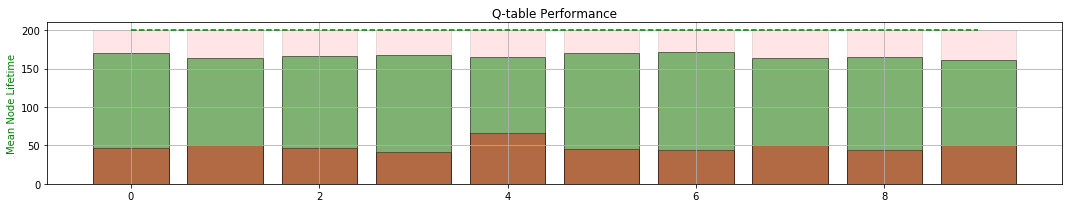

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 166.689	LOSS : 205.271	LOSS : 186.046	LOSS : 186.466	LOSS : 154.261	LOSS : 160.886	LOSS : 155.125	LOSS : 188.884	LOSS : 182.328	LOSS : 188.940	LOSS : 150.251	LOSS : 192.128	LOSS : 173.902	LOSS : 198.019	LOSS : 183.719	LOSS : 233.339	LOSS : 173.852	LOSS : 181.770	LOSS : 157.157	LOSS : 157.231	
Validating... MEAN TIME:  152.46
LOSS : 159.229	LOSS : 178.226	LOSS : 172.370	LOSS : 160.363	LOSS : 147.471	LOSS : 163.652	LOSS : 162.590	LOSS : 187.149	LOSS : 147.635	LOSS : 169.597	LOSS : 148.528	LOSS : 167.463	LOSS : 166.561	LOSS : 138.946	LOSS : 189.600	LOSS : 150.439	LOSS : 148.165	LOSS : 130.170	LOSS : 158.691	LOSS : 160.879	
Validating... MEAN TIME:  176.67
LOSS : 147.248	LOSS : 179.353	LOSS : 138.105	LOSS : 161.663	LOSS : 146.209	LOSS : 118.519	LOSS : 141.548	LOSS : 166.045	LOSS : 179.143	LOSS : 185.448	LOSS : 176.065	LOSS : 196.518	LOSS : 154.780	LOSS : 157.449	LOSS : 154.734	LOSS : 153.718	LOSS : 16

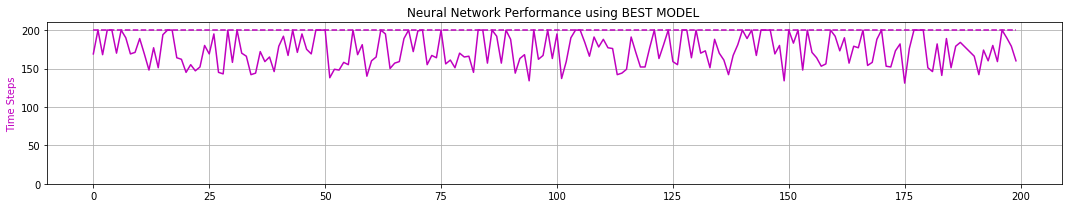

peak memory: 1484.98 MiB, increment: 1017.30 MiB
0 -max- [ 0.518  1.883  0.090  1.262]
0 -min- [-2.396 -3.307 -0.209 -1.991]

1 -max- [ 0.556  2.245  0.110  1.168]
1 -min- [-2.396 -3.480 -0.209 -2.425]

2 -max- [ 0.581  1.935  0.106  1.217]
2 -min- [-2.379 -3.325 -0.209 -1.986]

3 -max- [ 0.967  1.865  0.103  1.157]
3 -min- [-2.399 -3.325 -0.209 -1.986]

4 -max- [ 0.596  1.869  0.099  1.102]
4 -min- [-2.397 -3.329 -0.209 -1.991]

5 -max- [ 0.849  1.878  0.078  1.254]
5 -min- [-2.397 -3.320 -0.209 -1.988]

6 -max- [ 0.631  1.875  0.107  1.271]
6 -min- [-2.390 -3.331 -0.209 -1.972]

7 -max- [ 0.567  1.895  0.091  1.143]
7 -min- [-2.398 -3.321 -0.209 -2.160]

8 -max- [ 0.630  1.867  0.090  1.126]
8 -min- [-1.904 -2.961 -0.209 -1.986]

9 -max- [ 1.430  1.859  0.147  1.103]
9 -min- [-2.379 -3.286 -0.209 -2.204]

Quantization TIME:  0.02 minutes


ITERATION # 11
TOTAL EXPERIENCE GENERATED:   150233
SMALLEST TIMESTEP: 122
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1146620
TOTAL PARALLEL

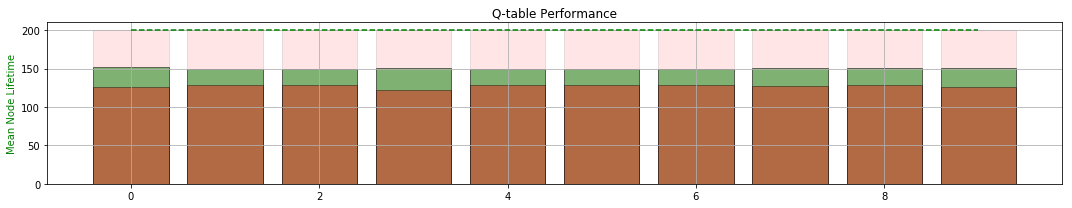

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 126.452	LOSS : 115.287	LOSS : 117.746	LOSS : 91.374	LOSS : 104.906	LOSS : 93.052	LOSS : 97.104	LOSS : 86.404	LOSS : 87.759	LOSS : 105.617	LOSS : 89.788	LOSS : 81.610	LOSS : 79.964	LOSS : 73.185	LOSS : 88.319	LOSS : 79.702	LOSS : 67.181	LOSS : 69.327	LOSS : 66.138	LOSS : 71.638	
Validating... MEAN TIME:  165.615
LOSS : 72.810	LOSS : 76.309	LOSS : 77.626	LOSS : 81.582	LOSS : 68.347	LOSS : 68.982	LOSS : 71.058	LOSS : 65.365	LOSS : 66.321	LOSS : 66.764	LOSS : 73.192	LOSS : 64.803	LOSS : 68.903	LOSS : 75.000	LOSS : 68.172	LOSS : 74.376	LOSS : 73.667	LOSS : 70.765	LOSS : 89.075	LOSS : 64.042	
Validating... MEAN TIME:  172.705
LOSS : 76.699	LOSS : 71.107	LOSS : 82.573	LOSS : 80.612	LOSS : 75.617	LOSS : 63.875	LOSS : 81.641	LOSS : 84.796	LOSS : 79.626	LOSS : 72.135	LOSS : 77.028	LOSS : 84.452	LOSS : 79.500	LOSS : 72.166	LOSS : 69.309	LOSS : 72.150	LOSS : 78.618	LOSS : 84.110	LOSS : 75.527	LOSS : 61.038	
V

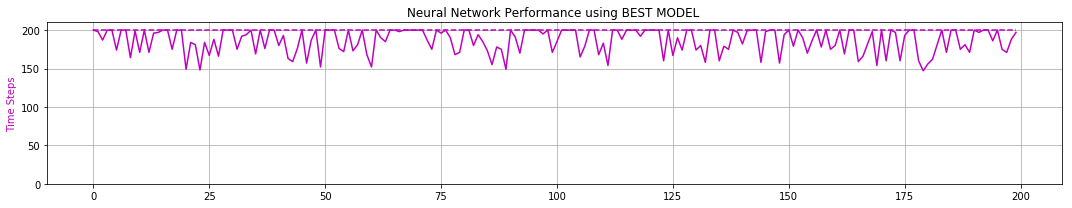

peak memory: 1466.34 MiB, increment: 1036.70 MiB
0 -max- [ 2.398  2.612  0.179  1.262]
0 -min- [-2.350 -2.973 -0.209 -1.776]

1 -max- [ 2.400  2.578  0.172  1.239]
1 -min- [-0.341 -0.816 -0.071 -1.183]

2 -max- [ 2.400  2.626  0.170  1.048]
2 -min- [-0.357 -0.630 -0.094 -1.230]

3 -max- [ 2.399  2.618  0.162  1.247]
3 -min- [-0.529 -0.951 -0.175 -1.205]

4 -max- [ 2.400  2.581  0.158  1.177]
4 -min- [-0.950 -1.684 -0.207 -1.268]

5 -max- [ 2.400  2.586  0.160  1.240]
5 -min- [-1.717 -2.413 -0.209 -1.269]

6 -max- [ 2.400  2.920  0.205  1.213]
6 -min- [-2.370 -2.937 -0.209 -1.196]

7 -max- [ 2.399  2.997  0.205  1.190]
7 -min- [-0.858 -1.505 -0.206 -1.132]

8 -max- [ 2.400  2.588  0.167  1.240]
8 -min- [-0.760 -1.308 -0.209 -1.202]

9 -max- [ 2.399  2.780  0.179  1.253]
9 -min- [-1.756 -2.420 -0.209 -1.184]

Quantization TIME:  0.01 minutes


ITERATION # 12
TOTAL EXPERIENCE GENERATED:   163874
SMALLEST TIMESTEP: 100
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1310494
TOTAL PARALLEL

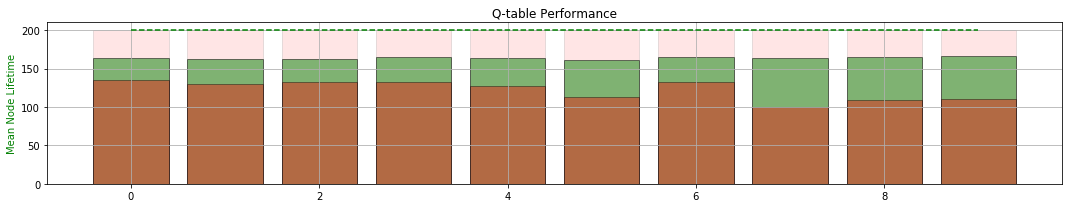

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 69.585	LOSS : 58.785	LOSS : 56.144	LOSS : 62.371	LOSS : 58.799	LOSS : 60.683	LOSS : 64.730	LOSS : 60.425	LOSS : 57.277	LOSS : 51.472	LOSS : 58.227	LOSS : 56.158	LOSS : 54.743	LOSS : 59.574	LOSS : 53.816	LOSS : 51.633	LOSS : 65.136	LOSS : 58.086	LOSS : 47.333	LOSS : 59.065	
Validating... MEAN TIME:  127.585
LOSS : 45.546	LOSS : 65.693	LOSS : 54.398	LOSS : 58.828	LOSS : 60.212	LOSS : 60.747	LOSS : 58.477	LOSS : 57.243	LOSS : 62.731	LOSS : 64.612	LOSS : 55.737	LOSS : 51.465	LOSS : 49.612	LOSS : 50.957	LOSS : 52.040	LOSS : 49.928	LOSS : 61.419	LOSS : 59.463	LOSS : 62.880	LOSS : 60.781	
Validating... MEAN TIME:  89.675
LOSS : 54.100	LOSS : 55.981	LOSS : 51.029	LOSS : 60.067	LOSS : 58.068	LOSS : 59.411	LOSS : 55.599	LOSS : 53.088	LOSS : 54.622	LOSS : 56.698	LOSS : 54.797	LOSS : 61.523	LOSS : 63.722	LOSS : 56.540	LOSS : 50.775	LOSS : 52.908	LOSS : 63.280	LOSS : 52.229	LOSS : 48.414	LOSS : 59.779	
Validat

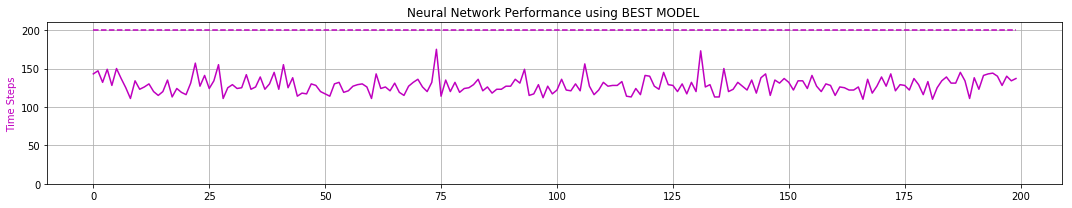

peak memory: 1473.60 MiB, increment: 985.22 MiB
0 -max- [ 2.400  2.774  0.175  1.867]
0 -min- [-1.174 -1.849 -0.209 -1.775]

1 -max- [ 2.400  2.592  0.165  1.655]
1 -min- [-0.771 -1.516 -0.208 -1.788]

2 -max- [ 2.400  2.621  0.168  1.654]
2 -min- [-0.876 -1.463 -0.209 -1.614]

3 -max- [ 2.400  2.427  0.185  1.651]
3 -min- [-0.854 -1.458 -0.208 -1.797]

4 -max- [ 2.400  2.432  0.171  1.733]
4 -min- [-1.154 -1.846 -0.209 -1.572]

5 -max- [ 2.399  2.623  0.175  1.629]
5 -min- [-1.196 -1.848 -0.209 -1.667]

6 -max- [ 2.399  2.615  0.172  1.663]
6 -min- [-0.830 -1.355 -0.207 -1.602]

7 -max- [ 2.400  2.620  0.209  1.832]
7 -min- [-1.117 -1.690 -0.209 -1.732]

8 -max- [ 2.399  2.619  0.178  1.662]
8 -min- [-2.379 -3.152 -0.208 -1.540]

9 -max- [ 2.400  2.578  0.193  1.812]
9 -min- [-0.902 -1.516 -0.208 -1.701]

Quantization TIME:  0.02 minutes


ITERATION # 13
TOTAL EXPERIENCE GENERATED:   129234
SMALLEST TIMESTEP: 15
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1439728
TOTAL PARALLEL T

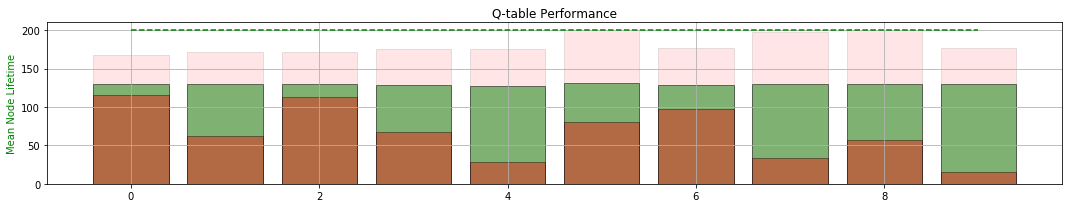

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 61.399	LOSS : 53.462	LOSS : 56.282	LOSS : 67.420	LOSS : 55.089	LOSS : 64.795	LOSS : 53.648	LOSS : 58.378	LOSS : 56.346	LOSS : 57.088	LOSS : 57.899	LOSS : 57.745	LOSS : 56.268	LOSS : 57.045	LOSS : 57.177	LOSS : 66.600	LOSS : 52.205	LOSS : 65.514	LOSS : 58.088	LOSS : 61.794	
Validating... MEAN TIME:  88.475
LOSS : 57.109	LOSS : 57.436	LOSS : 54.156	LOSS : 65.797	LOSS : 62.246	LOSS : 52.623	LOSS : 52.874	LOSS : 56.826	LOSS : 61.927	LOSS : 49.810	LOSS : 64.965	LOSS : 56.929	LOSS : 63.062	LOSS : 59.074	LOSS : 55.917	LOSS : 55.890	LOSS : 54.719	LOSS : 62.801	LOSS : 57.484	LOSS : 68.650	
Validating... MEAN TIME:  90.745
LOSS : 59.698	LOSS : 59.295	LOSS : 55.187	LOSS : 51.346	LOSS : 47.426	LOSS : 60.378	LOSS : 50.004	LOSS : 57.921	LOSS : 61.380	LOSS : 62.584	LOSS : 56.526	LOSS : 61.254	LOSS : 51.797	LOSS : 63.513	LOSS : 54.490	LOSS : 56.009	LOSS : 49.376	LOSS : 52.767	LOSS : 54.161	LOSS : 53.410	
Validati

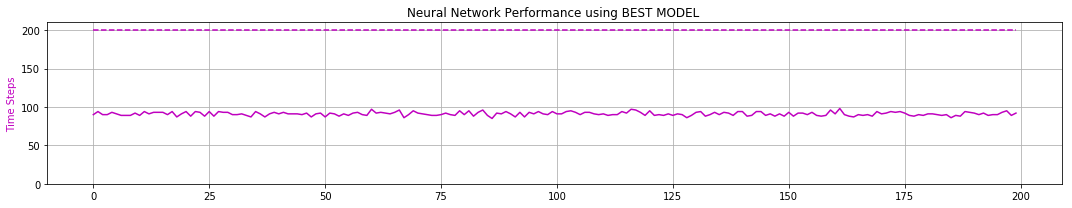

peak memory: 1513.76 MiB, increment: 977.85 MiB
0 -max- [ 2.400  2.789  0.192  1.692]
0 -min- [-0.161 -1.194 -0.089 -1.845]

1 -max- [ 2.400  2.758  0.209  1.719]
1 -min- [-0.167 -1.201 -0.113 -1.924]

2 -max- [ 2.400  2.754  0.189  1.694]
2 -min- [-0.138 -1.211 -0.096 -1.817]

3 -max- [ 2.400  2.915  0.206  1.851]
3 -min- [-0.132 -1.349 -0.141 -1.784]

4 -max- [ 2.400  2.764  0.208  1.788]
4 -min- [-0.156 -1.197 -0.105 -1.759]

5 -max- [ 2.400  2.748  0.203  1.914]
5 -min- [-0.656 -1.575 -0.205 -2.062]

6 -max- [ 2.399  2.756  0.204  1.859]
6 -min- [-0.159 -1.215 -0.099 -1.868]

7 -max- [ 2.399  2.739  0.206  1.980]
7 -min- [-0.160 -1.154 -0.136 -1.829]

8 -max- [ 2.399  2.796  0.208  1.908]
8 -min- [-0.186 -1.360 -0.125 -1.904]

9 -max- [ 2.400  2.725  0.206  1.832]
9 -min- [-0.149 -1.146 -0.145 -1.949]

Quantization TIME:  0.01 minutes


ITERATION # 14
TOTAL EXPERIENCE GENERATED:   48204
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 107
TOTAL SERIAL TIMESTEPS:   1487932
TOTAL PARALLEL TI

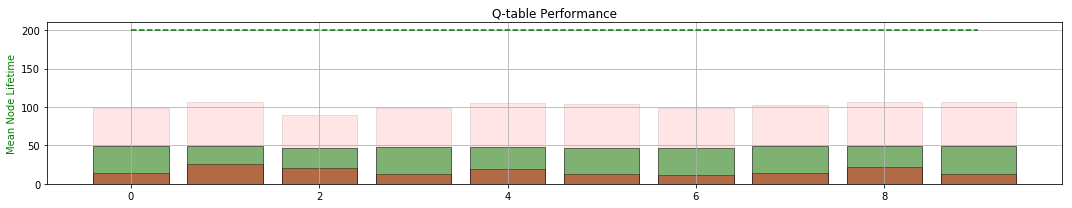

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 172.291	LOSS : 149.509	LOSS : 124.197	LOSS : 107.543	LOSS : 121.095	LOSS : 90.905	LOSS : 98.747	LOSS : 104.257	LOSS : 112.209	LOSS : 104.530	LOSS : 100.284	LOSS : 103.179	LOSS : 97.773	LOSS : 109.214	LOSS : 105.585	LOSS : 110.143	LOSS : 129.311	LOSS : 104.801	LOSS : 114.337	LOSS : 120.178	
Validating... MEAN TIME:  148.325
LOSS : 116.455	LOSS : 114.882	LOSS : 130.486	LOSS : 121.026	LOSS : 117.044	LOSS : 110.370	LOSS : 110.624	LOSS : 107.577	LOSS : 106.314	LOSS : 107.389	LOSS : 96.796	LOSS : 112.449	LOSS : 124.913	LOSS : 97.309	LOSS : 109.131	LOSS : 107.797	LOSS : 127.260	LOSS : 117.832	LOSS : 110.499	LOSS : 109.898	
Validating... MEAN TIME:  117.25
LOSS : 117.556	LOSS : 109.543	LOSS : 111.492	LOSS : 105.391	LOSS : 103.088	LOSS : 110.807	LOSS : 98.477	LOSS : 98.546	LOSS : 99.664	LOSS : 110.327	LOSS : 115.019	LOSS : 101.527	LOSS : 109.458	LOSS : 104.674	LOSS : 105.641	LOSS : 105.684	LOSS : 98.113	LO

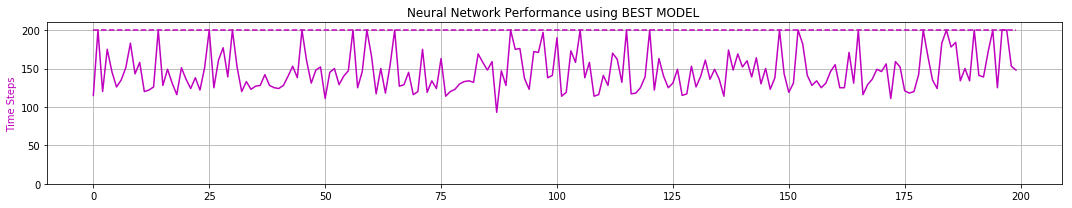

peak memory: 1452.26 MiB, increment: 1015.58 MiB
0 -max- [ 0.227  1.218  0.051  0.750]
0 -min- [-2.399 -3.523 -0.209 -1.730]

1 -max- [ 0.176  1.018  0.050  0.669]
1 -min- [-2.395 -3.467 -0.209 -1.470]

2 -max- [ 0.194  1.185  0.056  0.617]
2 -min- [-2.357 -3.499 -0.209 -1.748]

3 -max- [ 0.210  1.203  0.050  0.837]
3 -min- [-2.397 -3.643 -0.209 -1.750]

4 -max- [ 0.186  1.163  0.050  0.758]
4 -min- [-2.396 -3.504 -0.209 -1.733]

5 -max- [ 0.179  1.398  0.052  1.060]
5 -min- [-2.379 -3.533 -0.209 -1.958]

6 -max- [ 0.209  1.213  0.052  0.834]
6 -min- [-2.371 -3.671 -0.209 -1.797]

7 -max- [ 0.186  1.020  0.047  0.667]
7 -min- [-2.398 -3.506 -0.209 -1.503]

8 -max- [ 0.181  1.180  0.050  0.830]
8 -min- [-2.390 -3.651 -0.209 -1.754]

9 -max- [ 0.191  1.182  0.050  0.695]
9 -min- [-2.389 -3.532 -0.209 -1.723]

Quantization TIME:  0.01 minutes


ITERATION # 15
TOTAL EXPERIENCE GENERATED:   99255
SMALLEST TIMESTEP: 61
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1587187
TOTAL PARALLEL T

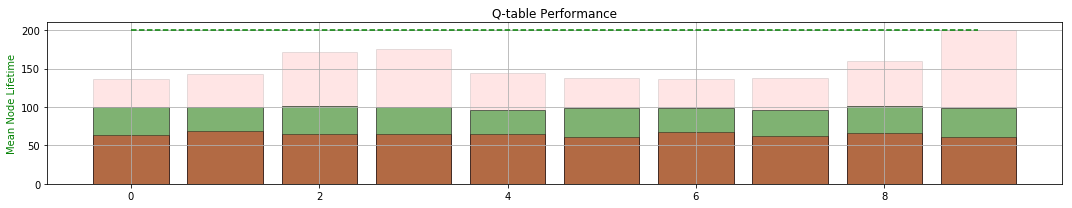

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 192.836	LOSS : 136.476	LOSS : 132.509	LOSS : 124.606	LOSS : 139.341	LOSS : 137.899	LOSS : 129.248	LOSS : 132.825	LOSS : 118.818	LOSS : 132.750	LOSS : 131.284	LOSS : 134.864	LOSS : 131.813	LOSS : 133.475	LOSS : 134.356	LOSS : 125.117	LOSS : 131.280	LOSS : 118.791	LOSS : 129.360	LOSS : 125.434	
Validating... MEAN TIME:  137.705
LOSS : 122.118	LOSS : 136.492	LOSS : 125.497	LOSS : 123.797	LOSS : 123.059	LOSS : 123.865	LOSS : 120.940	LOSS : 128.571	LOSS : 113.855	LOSS : 135.949	LOSS : 134.893	LOSS : 142.054	LOSS : 118.053	LOSS : 152.214	LOSS : 120.944	LOSS : 126.322	LOSS : 129.800	LOSS : 148.645	LOSS : 132.153	LOSS : 140.328	
Validating... MEAN TIME:  132.165
LOSS : 137.919	LOSS : 124.935	LOSS : 144.038	LOSS : 142.770	LOSS : 133.549	LOSS : 134.036	LOSS : 131.217	LOSS : 122.106	LOSS : 121.514	LOSS : 125.615	LOSS : 126.837	LOSS : 130.333	LOSS : 142.622	LOSS : 132.152	LOSS : 138.348	LOSS : 151.762	LOSS : 

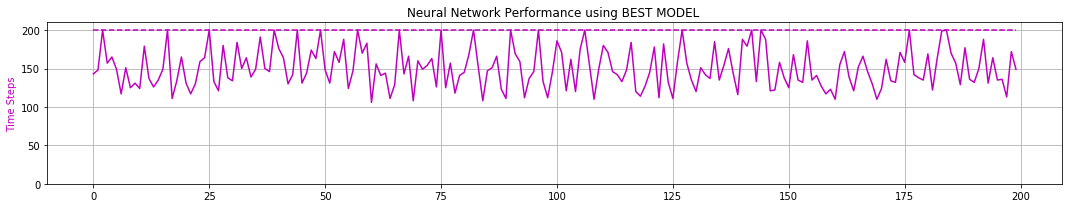

peak memory: 1461.38 MiB, increment: 1051.82 MiB
0 -max- [ 2.400  3.394  0.209  1.194]
0 -min- [-0.123 -0.821 -0.131 -1.683]

1 -max- [ 2.400  3.389  0.209  1.200]
1 -min- [-0.115 -0.820 -0.128 -1.655]

2 -max- [ 2.398  3.380  0.209  1.168]
2 -min- [-0.125 -0.898 -0.204 -1.662]

3 -max- [ 2.400  3.540  0.209  1.184]
3 -min- [-0.124 -0.817 -0.129 -1.904]

4 -max- [ 2.400  3.390  0.209  1.179]
4 -min- [-0.133 -0.825 -0.139 -1.676]

5 -max- [ 2.398  3.559  0.209  1.181]
5 -min- [-0.129 -0.817 -0.133 -1.808]

6 -max- [ 2.397  3.500  0.209  1.191]
6 -min- [-0.139 -0.824 -0.128 -1.674]

7 -max- [ 2.400  3.382  0.209  1.380]
7 -min- [-0.132 -0.977 -0.141 -1.657]

8 -max- [ 2.399  3.395  0.209  1.366]
8 -min- [-0.128 -1.002 -0.131 -1.678]

9 -max- [ 2.399  3.388  0.209  1.203]
9 -min- [-0.928 -1.976 -0.208 -1.664]

Quantization TIME:  0.01 minutes


ITERATION # 16
TOTAL EXPERIENCE GENERATED:   95881
SMALLEST TIMESTEP: 25
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1683068
TOTAL PARALLEL T

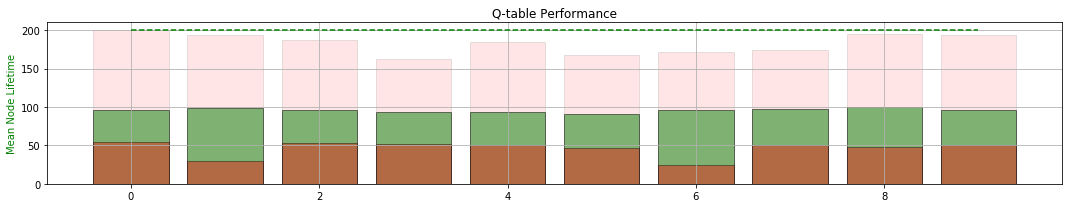

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 306.161	LOSS : 149.769	LOSS : 135.974	LOSS : 139.187	LOSS : 114.277	LOSS : 124.680	LOSS : 129.718	LOSS : 113.225	LOSS : 130.113	LOSS : 127.067	LOSS : 113.448	LOSS : 130.850	LOSS : 129.323	LOSS : 106.193	LOSS : 125.210	LOSS : 119.299	LOSS : 123.013	LOSS : 128.790	LOSS : 112.420	LOSS : 132.737	
Validating... MEAN TIME:  153.45
LOSS : 127.103	LOSS : 114.581	LOSS : 124.079	LOSS : 108.283	LOSS : 118.545	LOSS : 122.695	LOSS : 101.205	LOSS : 111.647	LOSS : 112.248	LOSS : 91.466	LOSS : 102.544	LOSS : 100.250	LOSS : 139.885	LOSS : 126.995	LOSS : 142.553	LOSS : 124.340	LOSS : 108.124	LOSS : 104.855	LOSS : 117.945	LOSS : 104.054	
Validating... MEAN TIME:  129.57
LOSS : 118.399	LOSS : 119.905	LOSS : 116.887	LOSS : 104.749	LOSS : 113.294	LOSS : 108.299	LOSS : 107.709	LOSS : 121.237	LOSS : 130.554	LOSS : 94.380	LOSS : 129.000	LOSS : 110.924	LOSS : 99.225	LOSS : 99.337	LOSS : 114.693	LOSS : 120.272	LOSS : 120.00

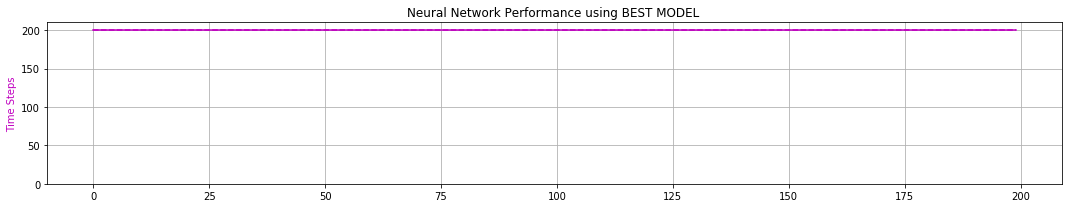

peak memory: 1503.40 MiB, increment: 1035.24 MiB
0 -max- [ 2.395  2.974  0.208  2.160]
0 -min- [-0.357 -1.380 -0.209 -2.046]

1 -max- [ 2.390  2.972  0.202  1.812]
1 -min- [-0.427 -1.369 -0.209 -1.944]

2 -max- [ 2.399  2.937  0.200  1.635]
2 -min- [-0.438 -1.364 -0.209 -1.678]

3 -max- [ 2.397  2.922  0.200  1.622]
3 -min- [-0.379 -1.543 -0.209 -1.676]

4 -max- [ 2.393  2.967  0.204  2.289]
4 -min- [-0.395 -1.720 -0.209 -1.957]

5 -max- [ 2.396  2.919  0.203  1.925]
5 -min- [-0.386 -1.372 -0.209 -1.875]

6 -max- [ 2.396  3.143  0.209  1.960]
6 -min- [-0.388 -1.570 -0.209 -1.812]

7 -max- [ 2.399  2.947  0.190  1.590]
7 -min- [-0.392 -1.386 -0.209 -1.659]

8 -max- [ 2.400  2.989  0.186  1.835]
8 -min- [-0.405 -1.374 -0.209 -1.923]

9 -max- [ 2.398  2.947  0.198  1.788]
9 -min- [-0.398 -1.380 -0.209 -1.767]

Quantization TIME:  0.02 minutes


ITERATION # 17
TOTAL EXPERIENCE GENERATED:   86082
SMALLEST TIMESTEP: 9
LARGEST  TIMESTEP: 169
TOTAL SERIAL TIMESTEPS:   1769150
TOTAL PARALLEL TI

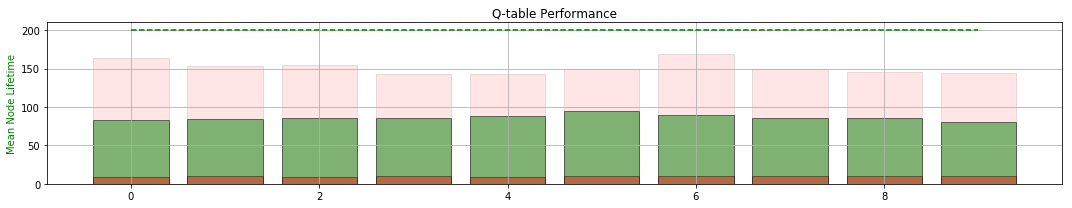

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 390.195	LOSS : 226.756	LOSS : 190.911	LOSS : 191.184	LOSS : 199.576	LOSS : 162.433	LOSS : 221.924	LOSS : 179.156	LOSS : 127.163	LOSS : 141.748	LOSS : 170.878	LOSS : 166.602	LOSS : 172.974	LOSS : 134.147	LOSS : 134.107	LOSS : 160.300	LOSS : 145.171	LOSS : 144.481	LOSS : 165.971	LOSS : 139.675	
Validating... MEAN TIME:  134.465
LOSS : 148.764	LOSS : 150.503	LOSS : 137.986	LOSS : 127.807	LOSS : 148.133	LOSS : 139.247	LOSS : 144.550	LOSS : 163.264	LOSS : 156.991	LOSS : 136.434	LOSS : 162.574	LOSS : 144.540	LOSS : 134.287	LOSS : 150.443	LOSS : 183.610	LOSS : 125.502	LOSS : 160.481	LOSS : 127.542	LOSS : 189.175	LOSS : 146.380	
Validating... MEAN TIME:  173.735
LOSS : 127.927	LOSS : 196.248	LOSS : 127.329	LOSS : 147.428	LOSS : 153.047	LOSS : 170.581	LOSS : 146.293	LOSS : 195.681	LOSS : 141.154	LOSS : 195.621	LOSS : 152.157	LOSS : 128.148	LOSS : 158.437	LOSS : 152.651	LOSS : 197.407	LOSS : 199.831	LOSS : 

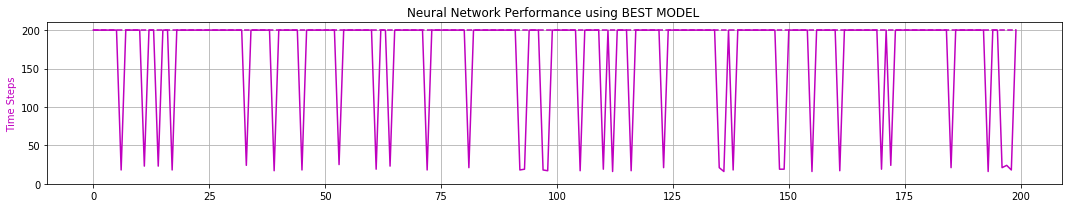

peak memory: 1465.30 MiB, increment: 1016.41 MiB
0 -max- [ 0.201  1.373  0.170  1.801]
0 -min- [-2.400 -2.391 -0.209 -2.046]

1 -max- [ 0.184  1.391  0.156  1.757]
1 -min- [-2.400 -2.391 -0.209 -1.992]

2 -max- [ 0.181  1.398  0.167  1.651]
2 -min- [-2.400 -2.238 -0.209 -1.975]

3 -max- [ 0.197  1.355  0.162  1.766]
3 -min- [-2.400 -2.392 -0.209 -1.992]

4 -max- [ 0.194  1.212  0.143  1.644]
4 -min- [-2.400 -2.261 -0.209 -1.980]

5 -max- [ 0.209  1.388  0.158  1.575]
5 -min- [-2.400 -2.448 -0.209 -1.971]

6 -max- [ 0.192  1.329  0.150  1.838]
6 -min- [-2.400 -2.399 -0.209 -2.260]

7 -max- [ 0.224  1.397  0.182  1.799]
7 -min- [-2.400 -2.414 -0.209 -1.996]

8 -max- [ 0.181  1.213  0.160  1.612]
8 -min- [-2.400 -2.374 -0.209 -1.976]

9 -max- [ 0.193  1.392  0.186  1.779]
9 -min- [-2.400 -2.426 -0.209 -1.994]

Quantization TIME:  0.01 minutes


ITERATION # 18
TOTAL EXPERIENCE GENERATED:   96481
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1865631
TOTAL PARALLEL T

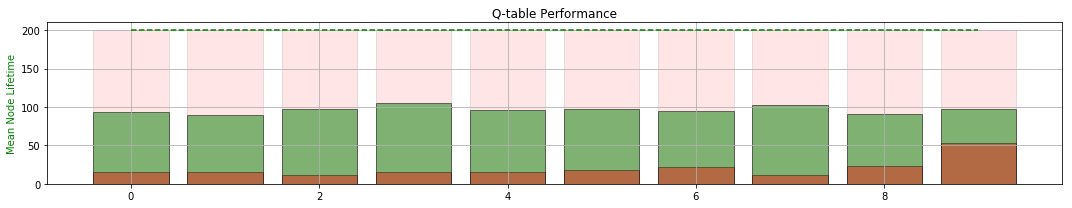

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 257.440	LOSS : 206.857	LOSS : 182.035	LOSS : 187.020	LOSS : 188.971	LOSS : 196.575	LOSS : 201.437	LOSS : 194.395	LOSS : 183.739	LOSS : 200.225	LOSS : 183.257	LOSS : 197.122	LOSS : 216.861	LOSS : 241.386	LOSS : 209.238	LOSS : 198.827	LOSS : 198.573	LOSS : 232.041	LOSS : 211.059	LOSS : 165.850	
Validating... MEAN TIME:  200.0
LOSS : 224.718	LOSS : 200.606	LOSS : 230.618	LOSS : 231.302	LOSS : 188.513	LOSS : 214.775	LOSS : 236.232	LOSS : 161.579	LOSS : 216.503	LOSS : 158.512	LOSS : 191.221	LOSS : 245.903	LOSS : 234.754	LOSS : 183.441	LOSS : 172.524	LOSS : 172.476	LOSS : 214.229	LOSS : 234.192	LOSS : 190.450	LOSS : 195.839	
Validating... MEAN TIME:  200.0
LOSS : 151.272	LOSS : 176.431	LOSS : 202.387	LOSS : 217.816	LOSS : 197.367	LOSS : 163.281	LOSS : 191.772	LOSS : 248.329	LOSS : 214.857	LOSS : 233.214	LOSS : 218.477	LOSS : 205.960	LOSS : 249.881	LOSS : 211.761	LOSS : 174.240	LOSS : 227.450	LOSS : 157.

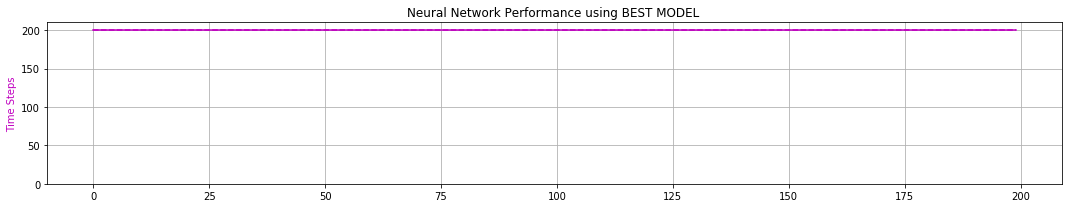

peak memory: 1457.88 MiB, increment: 1016.29 MiB
0 -max- [ 1.188  2.302  0.206  1.263]
0 -min- [-2.395 -3.614 -0.209 -1.666]

1 -max- [ 1.111  2.403  0.209  1.233]
1 -min- [-2.396 -3.493 -0.209 -1.925]

2 -max- [ 1.181  2.409  0.206  1.570]
2 -min- [-2.394 -3.637 -0.209 -1.889]

3 -max- [ 1.144  2.288  0.209  1.342]
3 -min- [-2.391 -3.686 -0.209 -1.676]

4 -max- [ 1.150  2.476  0.205  1.230]
4 -min- [-2.397 -3.635 -0.209 -1.684]

5 -max- [ 1.145  2.290  0.209  1.464]
5 -min- [-2.400 -3.713 -0.209 -1.674]

6 -max- [ 1.138  2.287  0.208  1.239]
6 -min- [-2.396 -3.521 -0.209 -1.729]

7 -max- [ 1.118  2.296  0.208  1.236]
7 -min- [-2.398 -3.686 -0.209 -1.674]

8 -max- [ 1.101  2.464  0.205  1.137]
8 -min- [-2.400 -3.650 -0.209 -1.913]

9 -max- [ 1.115  2.417  0.206  1.293]
9 -min- [-2.400 -3.705 -0.209 -1.809]

Quantization TIME:  0.01 minutes


ITERATION # 19
TOTAL EXPERIENCE GENERATED:   200000
SMALLEST TIMESTEP: 200
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   2065631
TOTAL PARALLEL

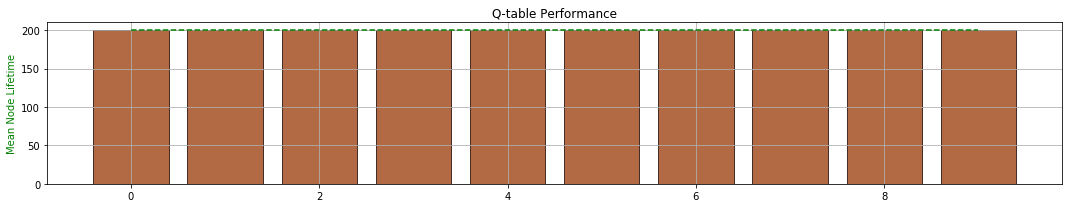

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  3323.0
Total Serial Timesteps   :  2065631.0
Speed-up                 :  621.62


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

   741 SUCCESS 200  19    3323    2065631     621.62
